In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss, f1_score, accuracy_score,precision_score, recall_score, roc_auc_score,multilabel_confusion_matrix
from sklearn.multioutput import ClassifierChain
from sklearn.ensemble import RandomForestClassifier

#Loading dataset
data = pd.read_csv("MCR.csv")

#cleaning of data there are no duplicates in the dataset.
data.dropna(inplace=True)

#Replacing % and mm with float type values in columns
data['Soil_Moisture_Level'] = data['Soil_Moisture_Level'].str.replace('%', '').astype(float)
data['Rainfall'] = data['Rainfall'].str.replace(' mm', '').astype(float)
data['Recommended_Crops'] = data['Recommended_Crops'].apply(eval)

#using a copy of data to make sure the initial dataset is used as backup in case of errors
modified_data = data.copy()

#grouping multiple crops under category to recommend multiple crops
def simplify_crop_list(crops):
    mapping = {
        'Rice': 'Cereal', 'Wheat': 'Cereal', 'Maize': 'Cereal',
        'Tomato': 'Vegetable', 'Brinjal': 'Vegetable', 'Chilli': 'Vegetable',
        'Groundnut': 'Oilseed', 'Sunflower': 'Oilseed',
        'Cotton': 'CashCrop', 'Sugarcane': 'CashCrop'
    }
    return list(set([mapping.get(crop, crop) for crop in crops]))


#applying grouping of crops on dataset
modified_data['Recommended_Crops'] = modified_data['Recommended_Crops'].apply(simplify_crop_list)

#using labelEncoder to consider varibale data into numerical values.
soil_encoder = LabelEncoder()
region_encoder = LabelEncoder()
season_encoder = LabelEncoder()

modified_data['Soil_Type'] = soil_encoder.fit_transform(modified_data['Soil_Type'])
modified_data['Region_Name'] = region_encoder.fit_transform(modified_data['Region_Name'])
modified_data['Season'] = season_encoder.fit_transform(modified_data['Season'])

#using multiLabel BInarizer for the data (groupd data)
X = modified_data.drop("Recommended_Crops", axis=1)
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(modified_data["Recommended_Crops"])

#Training the model using randomForestClassifier
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

base_model = RandomForestClassifier(n_estimators=100, random_state=42)
chains = [ClassifierChain(base_model, order='random', random_state=i) for i in range(5)]
predictions = [chain.fit(X_train, Y_train).predict(X_test) for chain in chains]

#predicting the average of y test.
Y_pred_avg = np.round(np.mean(predictions, axis=0))

#
hamming = hamming_loss(Y_test, Y_pred_avg)
subset_acc = accuracy_score(Y_test, Y_pred_avg)
f1_macro = f1_score(Y_test, Y_pred_avg, average='macro')

precision_macro = precision_score(Y_test, Y_pred_avg, average='macro', zero_division=0)
precision_micro = precision_score(Y_test, Y_pred_avg, average='micro', zero_division=0)
precision_weighted = precision_score(Y_test, Y_pred_avg, average='weighted', zero_division=0)

recall_macro = recall_score(Y_test, Y_pred_avg, average='macro', zero_division=0)
recall_micro = recall_score(Y_test, Y_pred_avg, average='micro', zero_division=0)
recall_weighted = recall_score(Y_test, Y_pred_avg, average='weighted', zero_division=0)

f1_micro = f1_score(Y_test, Y_pred_avg, average='micro', zero_division=0)
f1_weighted = f1_score(Y_test, Y_pred_avg, average='weighted', zero_division=0)

try:
    avg_proba = np.mean([chain.predict_proba(X_test) for chain in chains], axis=0)
    auc_macro = roc_auc_score(Y_test, avg_proba, average='macro', multi_class='ovr')
    auc_micro = roc_auc_score(Y_test, avg_proba, average='micro', multi_class='ovr')
except:
    auc_macro = "N/A (non-probabilistic)"
    auc_micro = "N/A (non-probabilistic)"

print("Model Evaluation:")
print("Hamming Loss:", hamming)
print("Subset Accuracy:", subset_acc)

print("")
print("Precision (macro):", precision_macro)
print("Precision (micro):", precision_micro)
print("Precision (weighted):", precision_weighted)

print("Recall (macro):", recall_macro)
print("Recall (micro):", recall_micro)
print("Recall (weighted):", recall_weighted)

print("F1 Score (macro):", f1_macro)
print("F1 Score (micro):", f1_micro)
print("F1 Score (weighted):", f1_weighted)

print("AUC-ROC (macro):", auc_macro)
print("AUC-ROC (micro):", auc_micro)

conf_matrices = multilabel_confusion_matrix(Y_test, Y_pred_avg, labels=range(len(mlb.classes_)))
for i, label in enumerate(mlb.classes_):
    print(f"\nConfusion Matrix for label: {label}")
    print(conf_matrices[i])


def predict_crop(soil_type, region_name, season, nitrogen, phosphorus, potassium, soil_moisture_percent, rainfall_mm):
    try:
        soil_type_encoded = soil_encoder.transform([soil_type])[0]
        region_encoded = region_encoder.transform([region_name])[0]
        season_encoded = season_encoder.transform([season])[0]
    except ValueError as e:
        print("Input error:", e)
        print("Ensure your inputs match the training data.")
        return []

    input_df = pd.DataFrame([[
        soil_type_encoded,
        nitrogen,
        phosphorus,
        potassium,
        float(soil_moisture_percent.replace('%', '')),
        float(rainfall_mm.replace(' mm', '')),
        region_encoded,
        season_encoded
    ]], columns=X.columns)

    user_preds = np.array([chain.predict(input_df)[0] for chain in chains])
    final_pred = np.round(np.mean(user_preds, axis=0))

    recommended_crops = mlb.inverse_transform(np.array([final_pred]))[0]
    return recommended_crops


print("\n Welcome to the Multi-Crop Recommendation System")
print("Please enter the following details:")

soil_type = input("Soil Type (e.g., Silty Loam, Sandy Loam, Loamy, Black Cotton Soil, Clayey: ")
region_name = input("Region Name (e.g., Odisha, West Bengal, Karnataka, Tamil Nadu, Andhra Pradesh, Maharashtra, Punjab: ")
season = input("Season (e.g., Kharif, Rabi, Zaid): ")

try:
    nitrogen = int(input("Nitrogen (N) value: "))
    phosphorus = int(input("Phosphorus (P) value: "))
    potassium = int(input("Potassium (K) value: "))
    soil_moisture_percent = input("Soil Moisture (e.g.,10-60): ")
    rainfall_mm = input("Rainfall (e.g., 300-1199 mm): ")
except ValueError:
    print("Please enter valid numeric values.")
    exit()
        
            
recommended = predict_crop(
    soil_type=soil_type,
    region_name=region_name,
    season=season,
    nitrogen=nitrogen,
    phosphorus=phosphorus,
    potassium=potassium,
    soil_moisture_percent=soil_moisture_percent,
    rainfall_mm=rainfall_mm
)
while True:
        if recommended:
            print("Recommended Crop Categories:")
            for crop in recommended:
                print(f" - {crop}")
        takeinput = input("\nDo you want to try again? (y/n): ").lower()
        if takeinput != 'y':
            break
        else:
            print("No suitable crops found. Please check your input values.")


Model Evaluation:
Hamming Loss: 0.0985101854667072
Subset Accuracy: 0.3076923076923077

Precision (macro): 0.670057915142362
Precision (micro): 0.6799431009957326
Precision (weighted): 0.6833872493595629
Recall (macro): 0.824517223848568
Recall (micro): 0.82842287694974
Recall (weighted): 0.82842287694974
F1 Score (macro): 0.7367527844905961
F1 Score (micro): 0.746875
F1 Score (weighted): 0.746963467875793
AUC-ROC (macro): 0.9482756408391613
AUC-ROC (micro): 0.9530317786537017

Confusion Matrix for label: Barley
[[247  16]
 [ 12  24]]

Confusion Matrix for label: CashCrop
[[124  47]
 [ 28 100]]

Confusion Matrix for label: Cereal
[[189  26]
 [  2  82]]

Confusion Matrix for label: Chickpea
[[237  20]
 [ 12  30]]

Confusion Matrix for label: Jute
[[248  18]
 [  4  29]]

Confusion Matrix for label: Mustard
[[242  11]
 [  9  37]]

Confusion Matrix for label: Oilseed
[[242  24]
 [  5  28]]

Confusion Matrix for label: Pulses
[[242  15]
 [  4  38]]

Confusion Matrix for label: Sorghum
[[236

Soil Type (e.g., Silty Loam, Sandy Loam, Loamy, Black Cotton Soil, Clayey:  Black Cotton Soil
Region Name (e.g., Odisha, West Bengal, Karnataka, Tamil Nadu, Andhra Pradesh, Maharashtra, Punjab:  Karnataka
Season (e.g., Kharif, Rabi, Zaid):  Zaid
Nitrogen (N) value:  30
Phosphorus (P) value:  40
Potassium (K) value:  20
Soil Moisture (e.g.,10-60):  45
Rainfall (e.g., 300-1199 mm):  800


Recommended Crop Categories:
 - CashCrop
 - Sorghum



Do you want to try again? (y/n):  n


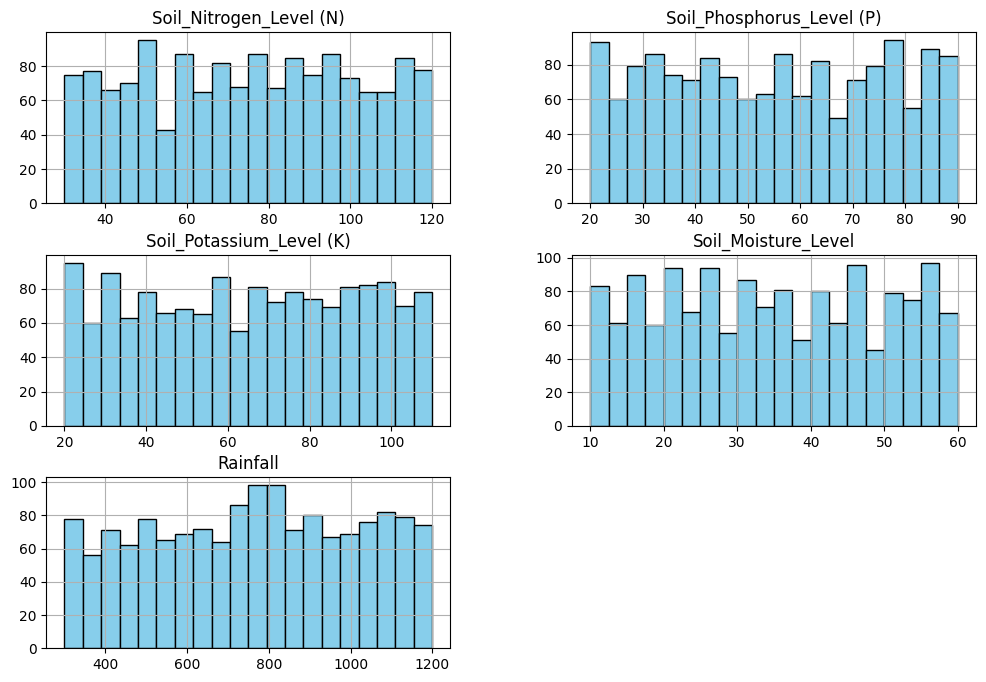

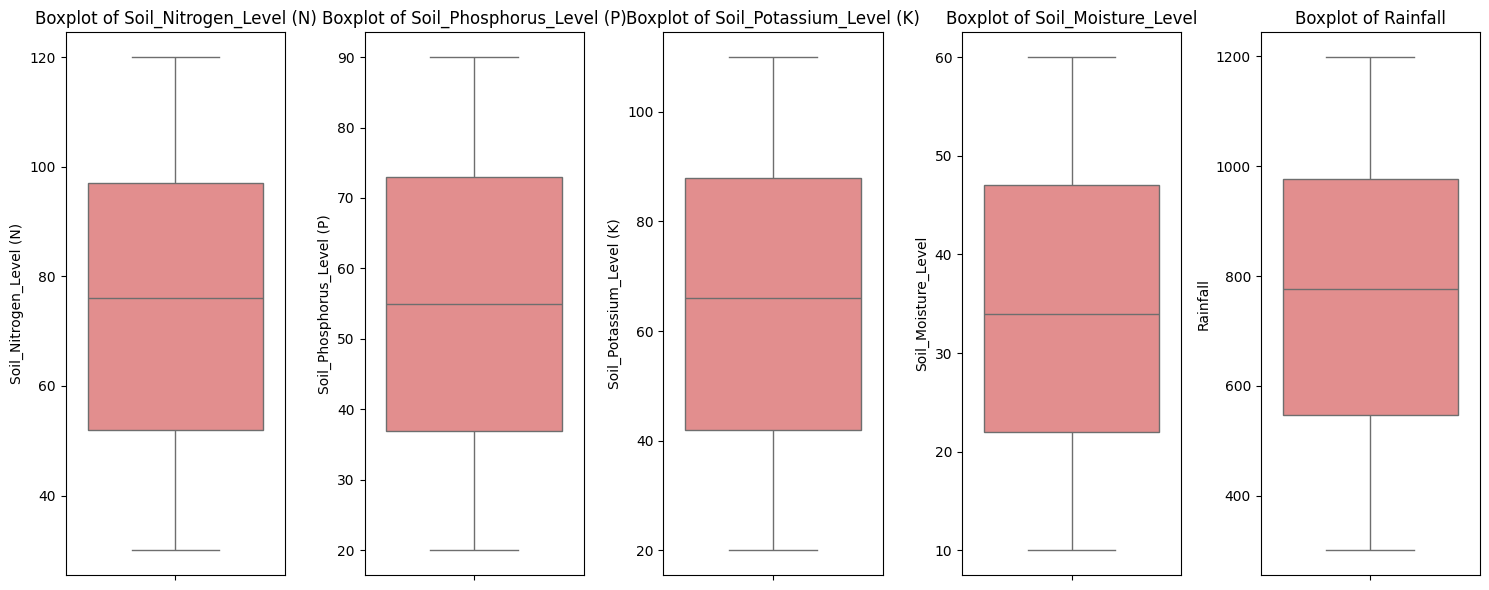

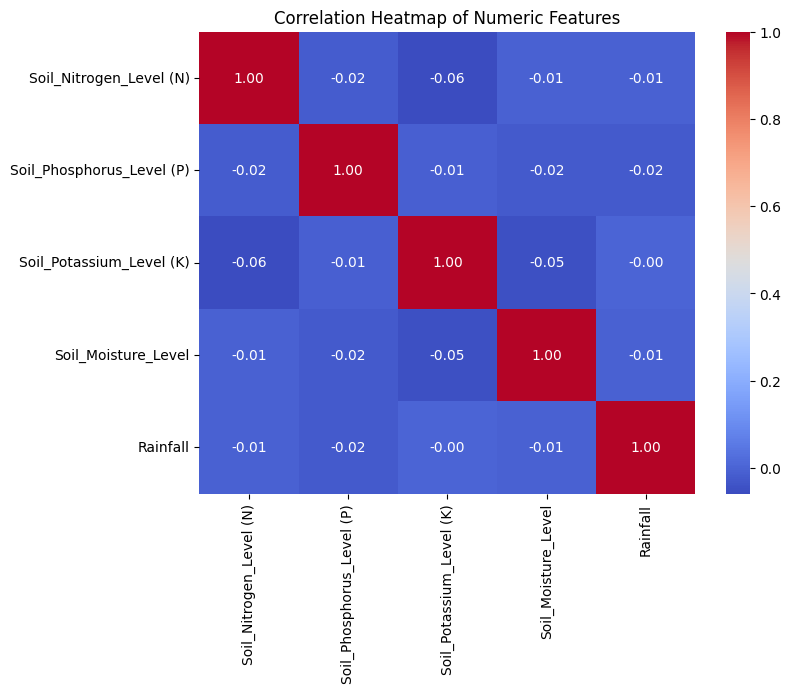


Key EDA Insights:
--------------------------------------------------
1. Histograms show the distribution of nutrient values and rainfall.
2. Boxplots reveal potential outliers in 'Potassium' and 'Rainfall'.
3. Correlation heatmap shows if any features are strongly correlated (watch Nitrogen & Phosphorus).
4. 'Rainfall' and 'Soil_Moisture_Level' might have a moderate correlation.
--------------------------------------------------
hamming loss: 0.09412326803631152
Accuracy score: 0.16387959866220736
f1-score: 0.6782050528404174
Precision (macro): 0.6754272259665682
Precision (micro): 0.6742671009771987
Precision (weighted): 0.6790358234328473
Recall (macro): 0.6891347014309612
Recall (micro): 0.680921052631579
Recall (weighted): 0.680921052631579
F1 Score (macro): 0.6782050528404174
F1 Score (micro): 0.6775777414075287
F1 Score (weighted): 0.6761699034672407
AUC-ROC (macro): 0.8160923558932665
AUC-ROC (micro): 0.8125119516930953

Confusion Matrix for label: Barley
[[249  14]
 [ 19  17]]

Soil Type e.g.,  Silty Loam, Sandy Loam, Loamy, Black Cotton Soil, Clayey:  Clayey
Region Name e.g.,  Odisha, West Bengal, Karnataka, Tamil Nadu, Andhra Pradesh, Maharashtra, Punjab:   Andhra pradesh
Season e.g., Kharif, Rabi, Zaid:  Zaid
Nitrogen (N) value:  30
Phosphorus (P) value:  20
Potassium (K) value:  110
Soil Moisture % (e.g., 35):  35
Rainfall in mm (e.g., 750):  750


*************** Input error**************** y contains previously unseen labels: 'Andhra pradesh'



Do you want to try again? (y/n):  y



 Welcome to the Multi-Crop Recommendation System
Please enter the following details:



Soil Type e.g.,  Silty Loam, Sandy Loam, Loamy, Black Cotton Soil, Clayey:  Clayey
Region Name e.g.,  Odisha, West Bengal, Karnataka, Tamil Nadu, Andhra Pradesh, Maharashtra, Punjab:   Andhra Pradesh
Season e.g., Kharif, Rabi, Zaid:  Zaid
Nitrogen (N) value:  30
Phosphorus (P) value:  20
Potassium (K) value:  110
Soil Moisture % (e.g., 35):  35
Rainfall in mm (e.g., 750):  750



=====Recommended Crops======
 - Jute
 - Sugarcane



Do you want to try again? (y/n):  n


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss,f1_score,accuracy_score,precision_score, recall_score, roc_auc_score,multilabel_confusion_matrix
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier

#loading the dataset
data=pd.read_csv("MCR.csv")

data.dropna(inplace=True)
data.drop_duplicates()


# removing percentage symbol from the Soil_moisture and removing millimeter from Rainfall
data['Soil_Moisture_Level'] = data['Soil_Moisture_Level'].str.replace('%', '').astype(float)
data['Rainfall'] = data['Rainfall'].str.replace(' mm', '').astype(float)

#converting recommended crops into list
data['Recommended_Crops']=data['Recommended_Crops'].apply(eval)



# Ploting histograms for numeric columns
numeric_cols = ['Soil_Nitrogen_Level (N)', 'Soil_Phosphorus_Level (P)', 'Soil_Potassium_Level (K)', 'Soil_Moisture_Level', 'Rainfall']
data[numeric_cols].hist(bins=20, figsize=(12, 8), color='skyblue', edgecolor='black')
plt.title("Histograms of Numeric Features")
plt.show()

# Boxplots for outlier detection
plt.figure(figsize=(15, 6))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, 5, i)
    sns.boxplot(y=data[col], color='lightcoral')
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# Heatmap for numerical colums in dataset
corr_matrix = data[numeric_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

# Key points/Insights from the graphs and plots
print("\nKey EDA Insights:")
print("-" * 50)
print("1. Histograms show the distribution of nutrient values and rainfall.")
print("2. Boxplots reveal potential outliers in 'Potassium' and 'Rainfall'.")
print("3. Correlation heatmap shows if any features are strongly correlated (watch Nitrogen & Phosphorus).")
print("4. 'Rainfall' and 'Soil_Moisture_Level' might have a moderate correlation.")
print("-" * 50)



#use Label Encoding to change sting data into int
#soil_labelencoder,region_labelencoder,season_labelencoder=LabelEncoder()

soil_labelencoder=LabelEncoder()
region_labelencoder=LabelEncoder()
season_labelencoder=LabelEncoder()

data["Soil_Type"]=soil_labelencoder.fit_transform(data["Soil_Type"])
data["Region_Name"]=region_labelencoder.fit_transform(data["Region_Name"])
data["Season"]=season_labelencoder.fit_transform(data["Season"])

#take Recommended_crop(Target) as Multibinarizer

copyofdata1=data.drop("Recommended_Crops",axis=1)
multiLabelbin=MultiLabelBinarizer()
copyofdata2=multiLabelbin.fit_transform(data["Recommended_Crops"])

#spliting the data as training and testing

train_x,test_x,train_y,test_y=train_test_split(copyofdata1,copyofdata2,test_size=0.2,random_state=42)

#implementing XGBoost

XGB=XGBClassifier()
model=MultiOutputClassifier(XGB)
model.fit(train_x,train_y)
pred_y_xgb = model.predict(test_x)

#predicting the output on testing labels

y_pred=model.predict(test_x)


def recommend_crop_from_user():
    print("\n Welcome to the Multi-Crop Recommendation System")
    print("Please enter the following details:\n")

    try:
        soil_type = input("Soil Type e.g.,  Silty Loam, Sandy Loam, Loamy, Black Cotton Soil, Clayey: ")
        region_name = input("Region Name e.g.,  Odisha, West Bengal, Karnataka, Tamil Nadu, Andhra Pradesh, Maharashtra, Punjab:  ")
        season = input("Season e.g., Kharif, Rabi, Zaid: ")

        nitrogen = int(input("Nitrogen (N) value: "))
        phosphorus = int(input("Phosphorus (P) value: "))
        potassium = int(input("Potassium (K) value: "))

        soil_moisture = float(input("Soil Moisture % (e.g., 35): "))
        rainfall = float(input("Rainfall in mm (e.g., 750): "))

        # Encoding categorical values
        soil_encoded = soil_labelencoder.transform([soil_type])[0]
        region_encoded = region_labelencoder.transform([region_name])[0]
        season_encoded = season_labelencoder.transform([season])[0]

        # Construct input row
        input_row = pd.DataFrame([[
            soil_encoded, nitrogen, phosphorus, potassium,
            soil_moisture, rainfall,
            region_encoded, season_encoded
        ]], columns=copyofdata1.columns)

        # Predict using the trained model
        prediction = model.predict(input_row)
        predicted_crops = multiLabelbin.inverse_transform(prediction)

        # Show result
        if predicted_crops and predicted_crops[0]:
            print("\n=====Recommended Crops======")
            for crop in predicted_crops[0]:
                print(f" - {crop}")
        else:
            print("\n========== No crops could be recommended for the given input. Please verify your values==========")

    except ValueError as ve:
        print("*************** Input error****************", ve)
    except Exception as e:
        print("************** Unexpected error**************", e)


#printing metrics

print("hamming loss:",hamming_loss(test_y,y_pred))
print("Accuracy score:",accuracy_score(test_y,y_pred))
print("f1-score:",f1_score(test_y,y_pred,average="macro"))
y_pred_avg = y_pred  # No thresholding/averaging done

# Correct typos
recall_macro = recall_score(test_y, y_pred_avg, average='macro', zero_division=0)
recall_micro = recall_score(test_y, y_pred_avg, average='micro', zero_division=0)
recall_weighted = recall_score(test_y, y_pred_avg, average='weighted', zero_division=0)

precision_macro = precision_score(test_y, y_pred_avg, average='macro', zero_division=0)
precision_micro = precision_score(test_y, y_pred_avg, average='micro', zero_division=0)
precision_weighted = precision_score(test_y, y_pred_avg, average='weighted', zero_division=0)

f1_macro = f1_score(test_y, y_pred_avg, average='macro', zero_division=0)
f1_micro = f1_score(test_y, y_pred_avg, average='micro', zero_division=0)
f1_weighted = f1_score(test_y, y_pred_avg, average='weighted', zero_division=0)

auc_macro = roc_auc_score(test_y, y_pred_avg, average='macro')
auc_micro = roc_auc_score(test_y, y_pred_avg, average='micro')

print("Precision (macro):", precision_macro)
print("Precision (micro):", precision_micro)
print("Precision (weighted):", precision_weighted)
print("Recall (macro):", recall_macro)
print("Recall (micro):", recall_micro)
print("Recall (weighted):", recall_weighted)
print("F1 Score (macro):", f1_macro)
print("F1 Score (micro):", f1_micro)
print("F1 Score (weighted):", f1_weighted)
print("AUC-ROC (macro):", auc_macro)
print("AUC-ROC (micro):", auc_micro)

conf_matrices = multilabel_confusion_matrix(test_y, y_pred_avg, labels=range(len(multiLabelbin.classes_)))
for i, label in enumerate(multiLabelbin.classes_):
    print(f"\nConfusion Matrix for label: {label}")
    print(conf_matrices[i])

while True:
    recommend_crop_from_user()
    takeinput = input("\nDo you want to try again? (y/n): ").lower()
    if takeinput != 'y':
        break




In [2]:
# Jupyter GUI using ipywidgets
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

# GUI imports
from ipywidgets import widgets, HBox, VBox, Layout, Output
from IPython.display import display, clear_output

# --------- Load + Prep (adapted from your script) ----------
data = pd.read_csv("MCR.csv")
data.dropna(inplace=True)
data = data.drop_duplicates()

# clean numeric strings
if 'Soil_Moisture_Level' in data.columns:
    data['Soil_Moisture_Level'] = data['Soil_Moisture_Level'].astype(str).str.replace('%','').astype(float)
if 'Rainfall' in data.columns:
    data['Rainfall'] = data['Rainfall'].astype(str).str.replace(' mm','').astype(float)

# ensure Recommended_Crops is list-like
data['Recommended_Crops'] = data['Recommended_Crops'].apply(eval)

# label encoders
soil_labelencoder = LabelEncoder()
region_labelencoder = LabelEncoder()
season_labelencoder = LabelEncoder()

data["Soil_Type"] = soil_labelencoder.fit_transform(data["Soil_Type"])
data["Region_Name"] = region_labelencoder.fit_transform(data["Region_Name"])
data["Season"] = season_labelencoder.fit_transform(data["Season"])

# prepare features / multi-label target
features = data.drop("Recommended_Crops", axis=1)
mlb = MultiLabelBinarizer()
targets = mlb.fit_transform(data["Recommended_Crops"])

# split and train
train_x, test_x, train_y, test_y = train_test_split(features, targets, test_size=0.2, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model = MultiOutputClassifier(xgb)
model.fit(train_x, train_y)

# ---------- Build ipywidget form ----------
# Use human-readable category lists for dropdowns:
soil_options = sorted(pd.Series(data['Soil_Type']).map(lambda v: None).unique())  # placeholder - we will map indices to labels below
# Instead get the original label strings from the encoder:
soil_labels = list(soil_labelencoder.classes_)
region_labels = list(region_labelencoder.classes_)
season_labels = list(season_labelencoder.classes_)

soil_dropdown = widgets.Dropdown(options=soil_labels, description='Soil Type:', layout=Layout(width='50%'))
region_dropdown = widgets.Dropdown(options=region_labels, description='Region:', layout=Layout(width='50%'))
season_dropdown = widgets.Dropdown(options=season_labels, description='Season:', layout=Layout(width='50%'))

nitrogen_input = widgets.BoundedIntText(value=20, min=0, max=1000, description='Nitrogen (N):', layout=Layout(width='40%'))
phosphorus_input = widgets.BoundedIntText(value=15, min=0, max=1000, description='Phosphorus (P):', layout=Layout(width='40%'))
potassium_input = widgets.BoundedIntText(value=10, min=0, max=1000, description='Potassium (K):', layout=Layout(width='40%'))

soil_moisture_input = widgets.BoundedFloatText(value=30.0, min=0.0, max=100.0, step=0.1, description='Soil Moisture (%):', layout=Layout(width='40%'))
rainfall_input = widgets.BoundedFloatText(value=500.0, min=0.0, max=10000.0, step=0.1, description='Rainfall (mm):', layout=Layout(width='40%'))

predict_button = widgets.Button(description='Predict', button_style='success')
output = Output(layout={'border': '1px solid gray'})

# helper: encode chosen categorical values
def encode_choice(val, encoder):
    # safer transform: find index in encoder.classes_
    try:
        idx = list(encoder.classes_).index(val)
        return idx
    except ValueError:
        # fallback to mode (most frequent) if not found
        return 0

def on_predict_clicked(b):
    with output:
        clear_output()
        try:
            soil_enc = encode_choice(soil_dropdown.value, soil_labelencoder)
            region_enc = encode_choice(region_dropdown.value, region_labelencoder)
            season_enc = encode_choice(season_dropdown.value, season_labelencoder)

            row = pd.DataFrame([[
                soil_enc,
                int(nitrogen_input.value),
                int(phosphorus_input.value),
                int(potassium_input.value),
                float(soil_moisture_input.value),
                float(rainfall_input.value),
                region_enc,
                season_enc
            ]], columns=features.columns)

            pred = model.predict(row)
            crops = mlb.inverse_transform(pred)
            if crops and len(crops[0])>0:
                print("Recommended crops:")
                for c in crops[0]:
                    print(" -", c)
            else:
                print("No crops recommended for this exact input. You may try different values.")
        except Exception as e:
            print("Error during prediction:", e)

predict_button.on_click(on_predict_clicked)

# layout
row1 = HBox([soil_dropdown, region_dropdown])
row2 = HBox([season_dropdown])
row3 = HBox([nitrogen_input, phosphorus_input, potassium_input])
row4 = HBox([soil_moisture_input, rainfall_input])
ui = VBox([row1, row2, row3, row4, predict_button, output])

display(ui)
